# The $\Lambda(C)$ processing. 

In [1]:
import sys
src = './auxiliary/'
sys.path.append(src)
import detector

# Standard library imports
import os
import cv2
import sys
import glob
import time
from scipy.interpolate import interp2d

from tqdm import tqdm
import numpy as np
import scipy.signal as signal
from scipy import interpolate
import matplotlib.pyplot as plt
from skimage import img_as_float64
import matplotlib.patches as patches
from IPython.display import clear_output
from scipy.interpolate import griddata
from skimage import measure, img_as_ubyte
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pprint
import warnings;warnings.filterwarnings("ignore")
%matplotlib widget
%load_ext autoreload
%autoreload 2

## Inputs

In [2]:
startTime = time.time()
clear_output(wait=False) #flush memory
debug = 1
plot = 1
frame_id = 368
spatial_res = 0.05
fs = 12
min_contour_size = 0 #4#6
win = 5  # Window size for the Hann window
pairwise_stabilized = 1
fontsize = 28
save = 1
opt_res = 5 #subsample the ploting of optical flow result
clear=0

## Set the paths 

In [3]:
root_dir = "../data"
fstr = 'AA201503MAIN_'

loc_output_subdir = root_dir + "/loc_output/" 
optical_flow_matlab = root_dir +'/optical_flow_data/'
savedir = loc_output_subdir
imgdir = root_dir + "/ij2xy_mapping_data/"
workdir =imgdir #+'data/'
figdir_path = "../figs/"
fname_thresh = os.path.join(root_dir, f"{fstr}thresholds_from_pdf.csv")
frame_str = str(frame_id).zfill(6)
filename_ = f'ij2xy_mapping_data_{frame_str}.pkl' 
wave_datapath = os.path.join(workdir, filename_)

fignames = ['Full_images', 
            "Mask_outside_roi",
            "Potential_breakers",
            'Wave_elevation_map',
            "Optical_based_results",
            "Prep_contours",
            'Velocities_mag',
            'Velocities_along_contours',
            "Outward_vectors",
            "Breaking kinematics"]

figout = []
for i, figname in enumerate(fignames):
    figout.append(figdir_path + figname +'_0'+ str(frame_id )+ '.png')
    

#prepare where to store your data (e.g loc information per frame)
if not os.path.exists(savedir):
    print("creating data saving folder")
    os.makedirs(savedir)

fidstr = str(frame_id) #at any instance a new frame ID is extracted.   
datapth = savedir + fstr +'frame_'+str(frame_id).zfill(6) +"_optical_flow.pkl"

fname_savestats= savedir+'saved_stats/' + fstr +'frame_0'+str(frame_id) +"_unwrapped_angles.txt"
if not os.path.exists(savedir+'saved_stats/'):
    os.makedirs(savedir+'saved_stats/')


#calculated with the determine_brightness_threshold script; refer to ../../auxilary
print("Looking for mean pdf file ")
if os.path.exists( fname_thresh ):
    print("Found the orange & yellow threshold values, loading!")
intensity_thresh = np.genfromtxt(fname_thresh, delimiter=',')
yellow = intensity_thresh[1] #may be too conservative
orange = intensity_thresh[0] #peak value pickup fake whitecaps
brightness_threshold = yellow #change the threshold here
print(f'Now drawing contours on frame_a with a brigntness threshold of: {round(brightness_threshold,2)}') 

Looking for mean pdf file 
Found the orange & yellow threshold values, loading!
Now drawing contours on frame_a with a brigntness threshold of: 0.6


## Load the images

In [4]:
print(f"Looking for xy data: {wave_datapath} ") 

data_a = np.load(wave_datapath, allow_pickle=True)
print("Keys in data:", data_a.keys())

Xa = data_a['Xa']
Ya = data_a['Ya']
Za = data_a['Za']

Xb = data_a['Xb']
Yb = data_a['Yb']
Zb = data_a['Zb']

frame_a = data_a['Iia']
frame_b = data_a['Iib']


Looking for xy data: ../data/ij2xy_mapping_data/ij2xy_mapping_data_000368.pkl 
Keys in data: dict_keys(['Xa', 'Ya', 'Za', 'Xb', 'Yb', 'Zb', 'Iia', 'Iib'])


## visualize the image loaded

saving figure


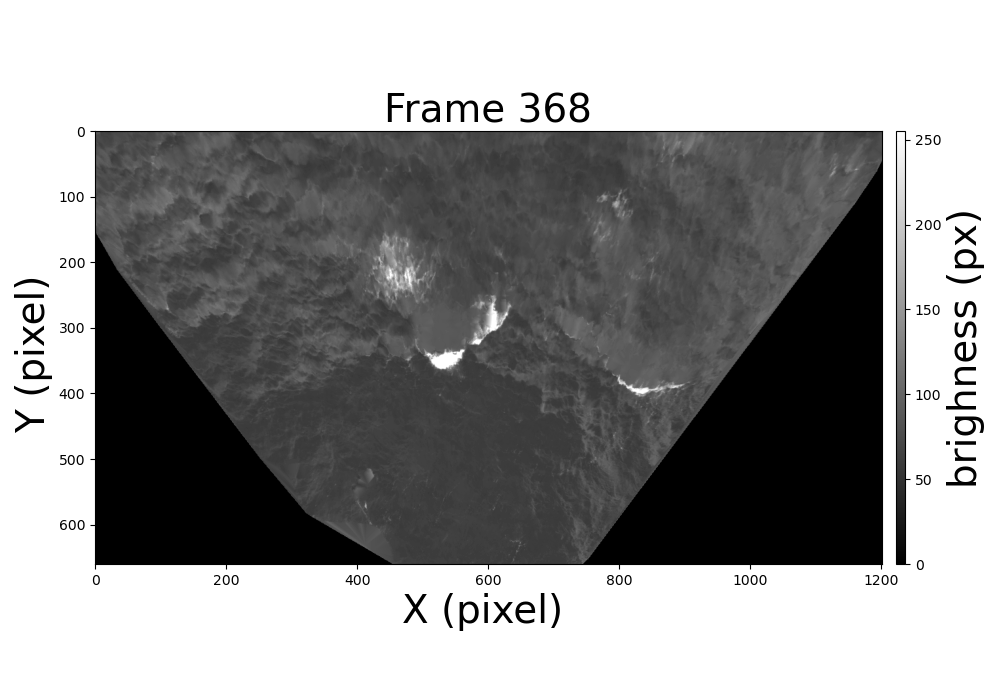

In [5]:
Ih,Iw = np.shape(frame_b)

if plot: 
    
    plt.figure(figsize=(10,7))
    ax = plt.gca()

    c =plt.imshow(frame_b, cmap = 'gray', 
               origin = 'upper')
    plt.title('Frame ' + str(frame_id), fontsize = fontsize)

    plt.xlabel('X (pixel) ' , fontsize = fontsize)
    plt.ylabel('Y (pixel) ' , fontsize = fontsize)
    plt.grid(True, which ='minor')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1.2%", pad=0.14)
    c=plt.colorbar(c, cax= cax, fraction=0.246)
    c.set_label('brighness (px)',fontsize = fontsize)
    plt.tight_layout()
    if save:
        plt.savefig(figout[0]); print('saving figure')

## Visualize the loaded wave data

saving figure


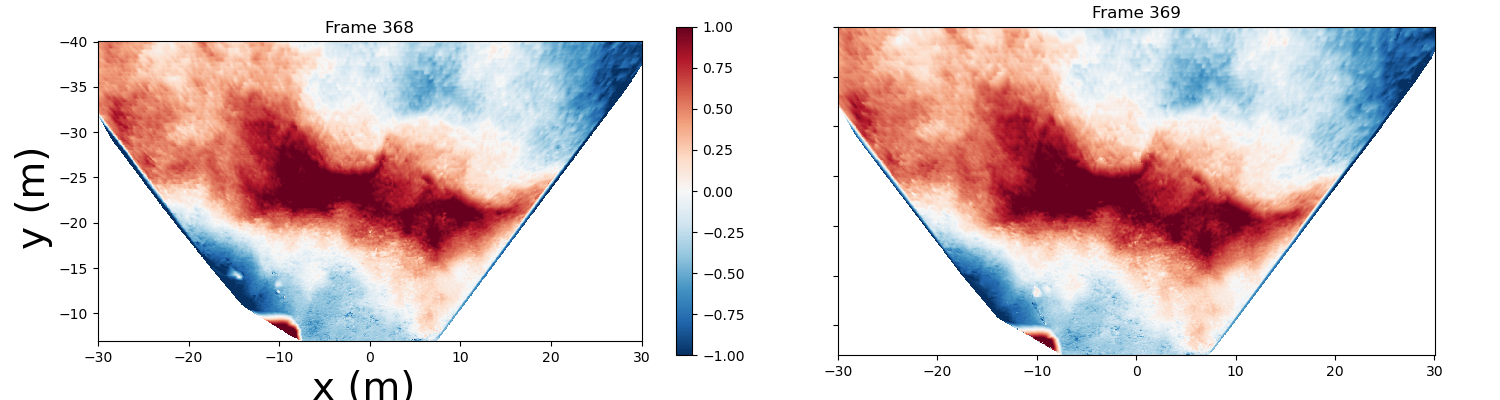

In [6]:
if plot:
    fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize= (15,4))

    c=ax[0].pcolor(Xa, Ya,Za,cmap = 'RdBu_r', vmin = -1, vmax =1)
    ax[1].pcolor(Xb, Yb,Zb,cmap = 'RdBu_r', vmin = -1, vmax =1)
    ax[0].title.set_text('Frame ' + str(frame_id))
    ax[1].title.set_text('Frame ' + str(frame_id +1))
    ax[0].set_xlabel('x (m) ' , fontsize=fontsize)
    ax[0].set_ylabel('y (m) ' , fontsize=fontsize)

    plt.gca().invert_yaxis()
    c = plt.colorbar(c)
    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    plt.tight_layout()
    if save:
        plt.savefig(figout[3]); print('saving figure')

## Skip breaker free imgs

In [7]:
# #------------------------------------ save data about no contour frames---------------------------------------------------   
# if 1 > len(contoursb):
#     pbar = tqdm(total=100) # Init my progress bar
#     aTOT = aTOT  #save this value if no breakers = nan
#     print('Skipped making figure')
#     #-----------------------------------------------------------------------------
#     pbar.update(50)    
#     if save:
#         print('saving the loc parameters')

#         detector.save_stats(datapth, frame_area= aTOT, n=frame_id)
#         detector.print_stats(aTOT, brightness_threshold, startTime, C=0)

## Load optical flow output

Loading Vx file: ../data/optical_flow_data/Vx_data_000368.csv
Loading Vy file: ../data/optical_flow_data/Vy_data_000368.csv


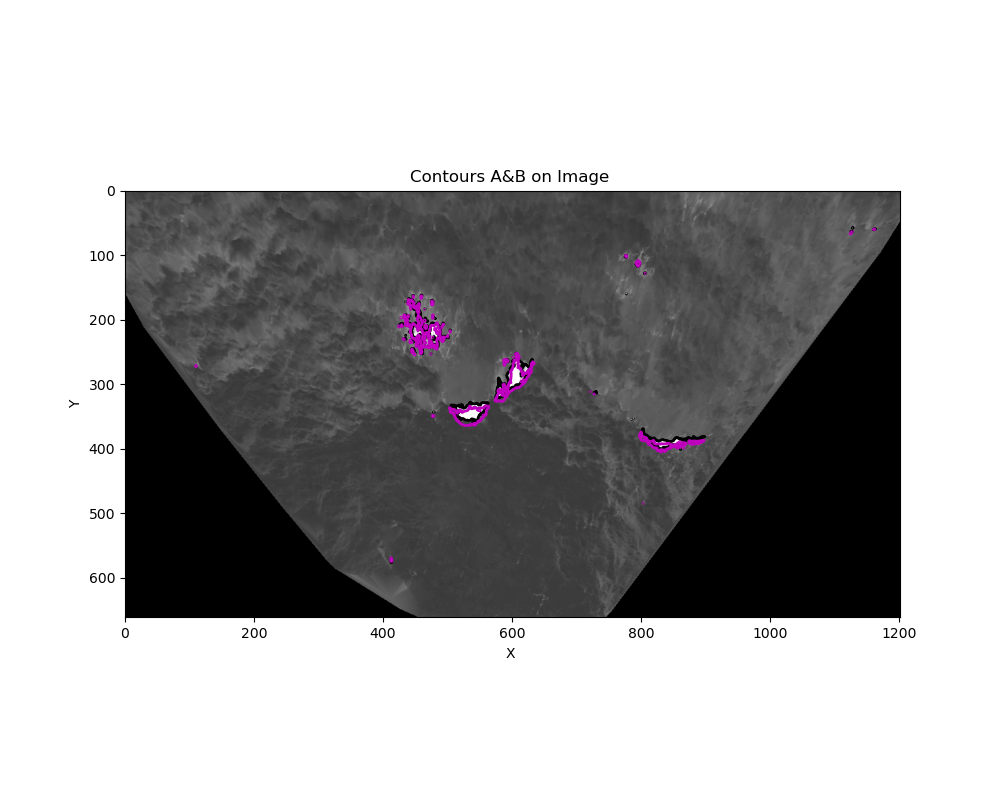

saving figure


In [8]:
# Generate the filenames for Vx and Vy data
vx_filename = f'{optical_flow_matlab}Vx_data_{str(frame_id).zfill(6)}.csv'
vy_filename = f'{optical_flow_matlab}Vy_data_{str(frame_id).zfill(6)}.csv'

print(f"Loading Vx file: {vx_filename}")
print(f"Loading Vy file: {vy_filename}")

flow_x_phys = np.loadtxt(vx_filename, delimiter=',')
flow_y_phys = np.loadtxt(vy_filename, delimiter=',')

plt.figure(figsize=(10, 8))
plt.imshow(frame_a, cmap='gray')

plt.contour(frame_a, levels=[brightness_threshold*255], colors='k', linewidths=2)
plt.contour(frame_b, levels=[brightness_threshold*255], colors='m', linewidths=2)
plt.xlim(0, flow_y_phys.shape[1])
plt.ylim(flow_y_phys.shape[0], 0)  
plt.title('Contours A&B on Image ')
plt.xlabel('X ')
plt.ylabel('Y')
plt.show()
if save:
    plt.savefig(figout[2]); print('saving figure')

## Cal. the velocities

It took: 0.0012309551239013672 secs to mesh
It took: 21.872830867767334 secs to gen interp


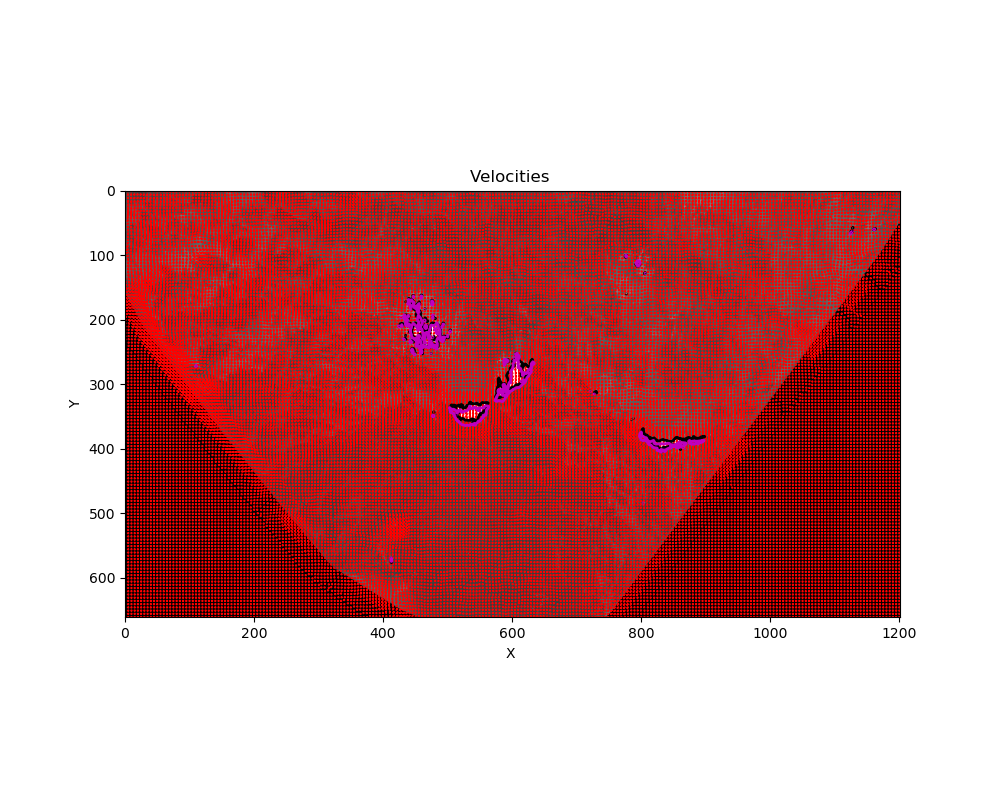

saving figure


In [9]:
dt = 1/fs

cx = flow_x_phys * spatial_res/dt
cy = flow_y_phys * spatial_res/dt

cx = np.nan_to_num(cx, copy=True, nan=0.0, posinf=None, neginf=None)
cy = np.nan_to_num(cy, copy=True, nan=0.0, posinf=None, neginf=None)

tic = time.time()
J, I = np.meshgrid(np.arange(Iw), np.arange(Ih))
print('It took:', time.time() - tic, 'secs to mesh')


interpolator_cx = detector.interpolate(I,J,cx)
interpolator_cy = detector.interpolate(I,J,cy)
print('It took:', time.time() - tic, 'secs to gen interp')


plt.figure(figsize=(10, 8))
plt.imshow(frame_a, cmap='gray')

for i in range(0, cy.shape[0], opt_res):  
    for j in range(0, cy.shape[1], opt_res):
        plt.arrow(j, i, cx[i, j], cy[i, j], 
                  head_width=2, head_length=2, fc='r', ec='r')

plt.contour(frame_a, levels=[brightness_threshold*255], colors='k', linewidths=2)
plt.contour(frame_b, levels=[brightness_threshold*255], colors='m', linewidths=2)
plt.xlim(0, flow_y_phys.shape[1])
plt.ylim(flow_y_phys.shape[0], 0)  
plt.title('Velocities ')
plt.xlabel('X ')
plt.ylabel('Y')
plt.show()
if save:
    plt.savefig(figout[4]); print('saving figure')

## prep the contours

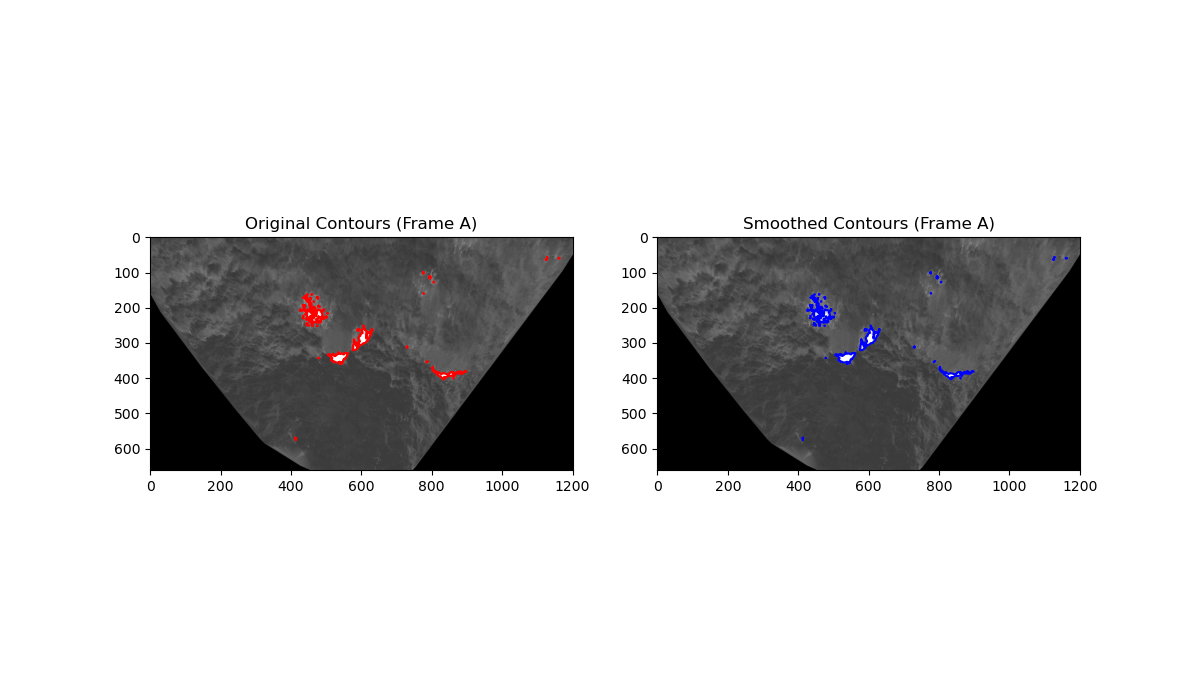

saving figure
Have successfully interpolated the velocities along the contours


In [10]:
threshold_value = brightness_threshold * 255

# Thresholding the frames
_, thresholded_a = cv2.threshold(frame_a, threshold_value, 255, cv2.THRESH_BINARY)
_, thresholded_b = cv2.threshold(frame_b, threshold_value, 255, cv2.THRESH_BINARY)

contour_levels = [threshold_value]  # Contour at the threshold level
contour_plot_a = plt.contour(thresholded_a, levels=contour_levels)
contour_plot_b = plt.contour(thresholded_b, levels=contour_levels)
plt.close()

# Get contours from the plots
contours_a = detector.extract_contours_from_plot(contour_plot_a)
contours_b = detector.extract_contours_from_plot(contour_plot_b)

# Apply smoothing to the contours
smoothed_contours_a = [detector.smooth_contour(contour, win) for contour in contours_a]
smoothed_contours_b = [detector.smooth_contour(contour, win) for contour in contours_b]

if plot:
    plt.figure(figsize=(12, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(frame_a, cmap='gray')
    for contour in contours_a:
        plt.plot(contour[:, 0], contour[:, 1], 'r-', label='Original Contour')
    plt.title('Original Contours (Frame A)')
    #plt.axis('equal')

    # Smoothed contours
    plt.subplot(1, 2, 2)
    plt.imshow(frame_a, cmap='gray')
    for contour in smoothed_contours_a:
        plt.plot(contour[:, 0], contour[:, 1], 'b-', label='Smoothed Contour')
    plt.title('Smoothed Contours (Frame A)')
    #plt.axis('equal')

    #plt.tight_layout()
    plt.show()

    if save:
        plt.savefig(figout[5]); print('saving figure')


# Create grid for cx and cy (same size as cx/cy arrays)
I, J = np.meshgrid(np.arange(cx.shape[1]), np.arange(cx.shape[0]))

# Use linear interpolation for both cx and cy fields
interp_cx = interp2d(I[0, :], J[:, 0], cx, kind='linear')
interp_cy = interp2d(I[0, :], J[:, 0], cy, kind='linear')

# Initialize empty lists to store interpolated values
CXi_list = []
CYi_list = []
ipc_list = []
jpc_list = []

# Iterate over smoothed contours and interpolate them onto cx and cy
for contour in smoothed_contours_a:
    x_contour, y_contour = contour[:, 0], contour[:, 1]
    
    for x_point, y_point in zip(x_contour, y_contour):
        # Interpolate cx and cy at each point of the contour
        cx_val = interp_cx(x_point, y_point)[0]  # [0] extracts the scalar value
        cy_val = interp_cy(x_point, y_point)[0]  # [0] extracts the scalar value
        
        # Store the interpolated values and coordinates
        CXi_list.append(cx_val)
        CYi_list.append(cy_val)
        ipc_list.append(x_point)  # x coordinates (columns)
        jpc_list.append(y_point)  # y coordinates (rows)

# Convert lists to 1D numpy arrays
CXi = np.array(CXi_list)
CYi = np.array(CYi_list)
ipc = np.array(ipc_list)
jpc = np.array(jpc_list)
print('Have successfully interpolated the velocities along the contours')

## Inspect the magnitudes of the velocities

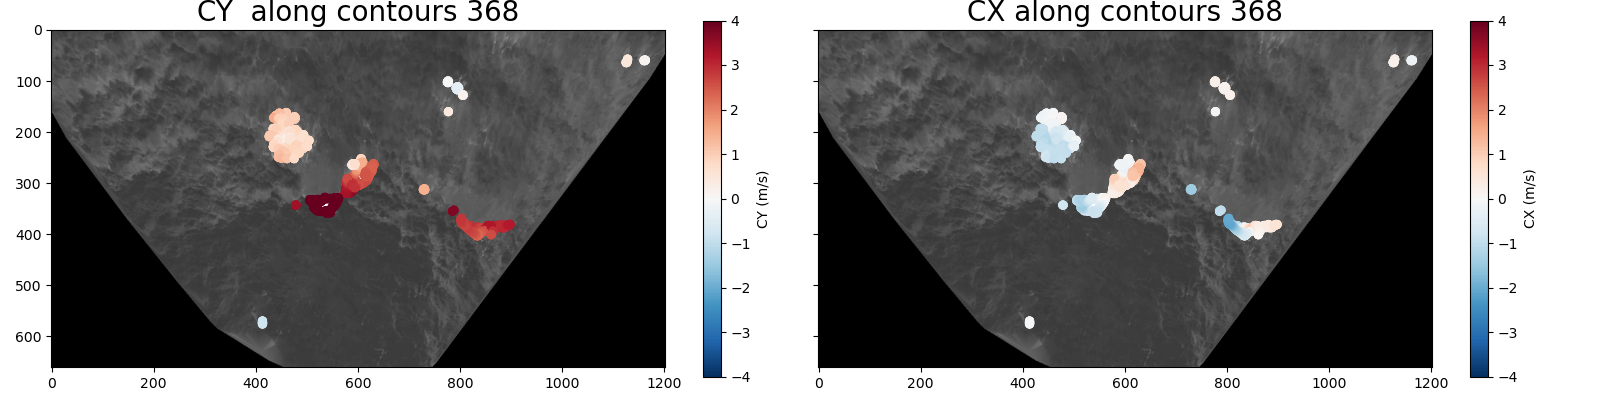

saving figure


In [11]:
if plot:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)

    ax1.imshow(frame_a, cmap='gray')

    scatter1 = ax1.scatter(ipc, jpc, s=30, c=CYi, cmap='RdBu_r', vmin=-4, vmax=4)
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label("CY (m/s)")
    ax1.set_title("CY  along contours " + str(frame_id), fontsize=20)
    ax1.set_aspect('equal')

    ax2.imshow(frame_a, cmap='gray')
    scatter2 = ax2.scatter(ipc, jpc, s=30, c=CXi, cmap='RdBu_r', vmin=-4, vmax=4)
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label("CX (m/s)")
    ax2.set_title("CX along contours " + str(frame_id), fontsize=20)
    ax2.set_aspect('equal')

    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig(figout[6]); print('saving figure')


## Inspect what goes into outward vector cal.

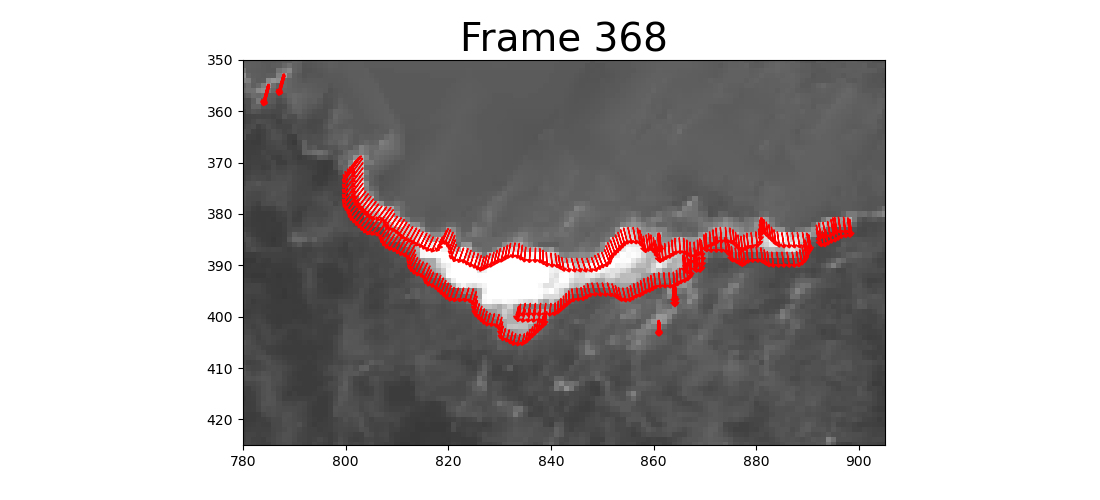

saving figure


In [12]:
if plot:
    amp = 1#10
    plt.figure(figsize=(11,5))
    plt.imshow(frame_a, cmap='gray', vmin = 150)
    for x_start, y_start, dx, dy in zip(ipc, jpc, CXi, CYi):
        plt.arrow(x_start, y_start, dx*amp, dy*amp, 
                  length_includes_head=True, 
                  head_length=0.5, 
                  head_width=1, 
                  ec='red', 
                  facecolor='red')

    plt.imshow(frame_a, cmap='gray')
    plt.xlim([780, 905])
    plt.ylim([425,350 ])

    plt.title('Frame ' + str(frame_id ), fontsize=fontsize)
    plt.show()
    if save:
        plt.savefig(figout[7]); print('saving figure')


## Get the Outward Vectors

Finding the outward vectors
saving figure


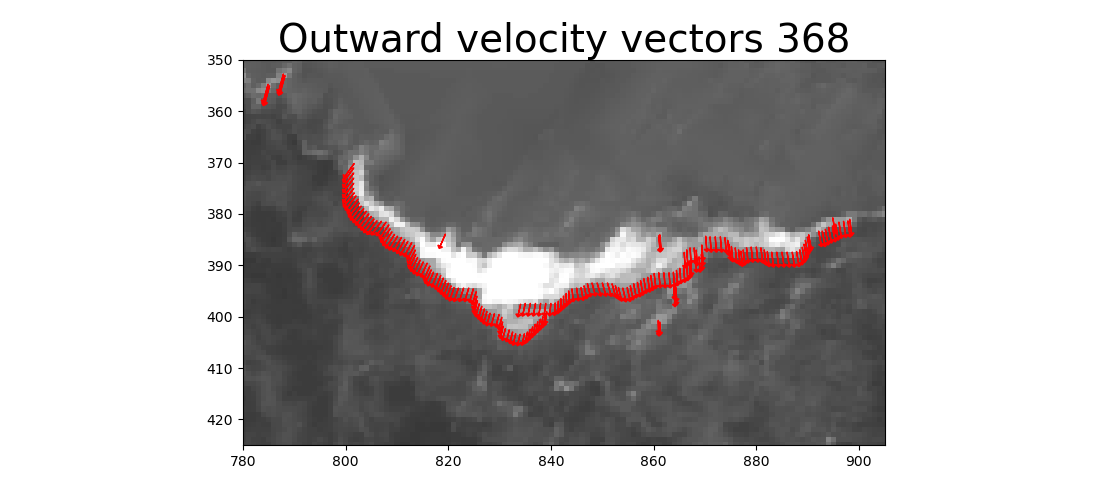

In [13]:

dXipc = list()
dYjpc = list()

# Check if jpc has elements
if len(jpc) > 0:
    # Difference the ys
    dYjpc = jpc[1:len(jpc)] - jpc[0:len(jpc) - 1]
    tmpy = jpc[0] - jpc[len(jpc) - 1]
    dYjpc = np.append(dYjpc, tmpy)  # appending looped values during differentiation

# Check if ipc has elements
if len(ipc) > 0:
    # Difference the xs
    dXipc = ipc[1:len(ipc)] - ipc[0:len(ipc) - 1]
    tmpx = ipc[0] - ipc[len(ipc) - 1]
    dXipc = np.append(dXipc, tmpx)

print('Finding the outward vectors')

# normal outward vector to the contours
nCX = -1 * (dYjpc)
nCY = dXipc


nxp  = nCX * CXi + nCY*CYi  #project our velocities (as evaluated on the contours) onto the normal vectors     
outward_vec = np.argwhere(nxp<0) # find the projection that is less than zero == outward vector

inpo, jnpo, nCXo, nCYo = ipc[outward_vec], jpc[outward_vec], nCX[outward_vec], nCY[outward_vec] #the o stands for outward vector
CXo, CYo = np.array(CXi)[outward_vec.astype(int)], np.array(CYi)[outward_vec.astype(int)]

l2,l1 =np.shape(CXo)
if plot:
    plt.figure(figsize=(11,5))
    plt.imshow(frame_a, cmap='gray')
    # plt.pcolor(Xa, Ya, frame_b0, cmap='gray', shading='auto')
    for i in range(l2):
        for j in range(l1):
            plt.arrow(inpo[i][j], jnpo[i][j], CXo[i][j], CYo[i][j], length_includes_head=True,head_length=0.5, head_width= 1, ec ='red',facecolor='red')
    plt.title('Outward velocity vectors ' + str(frame_id), fontsize = fontsize)
    plt.gca().set_aspect('equal')
    plt.xlim([780, 905])
    plt.ylim([425,350 ])
    if save:
        plt.savefig(figout[8]); print('saving figure')

## (optional) Drop speeds <1m/s

In [14]:

## compute the derivatives 
Dxy,Dxx = np.gradient(Xa) #Dxx ==dx
Dyy,Dyx = np.gradient(Ya) #Dyy ==dy
print("X and Y gradients gotten!")
aTOT = np.nansum(np.nansum(Dxx *Dyy))

interpolator_dx, interpolator_dy = detector.interpolate(Xa, Ya, Dxx), detector.interpolate(Xa, Ya, Dyy)
ipo, jpo = inpo +0, jnpo+0  #shifts the i prime field


#evaluate the ipo,jpo on the x space
dy, dx =  [interpolator_dy(ipo[j], jpo[j]) for j in range(len(jpo))], [interpolator_dx(ipo[i], jpo[i]) for i in range(len(ipo))]
#pbar.update(12)

theta = np.arctan(abs(CYo)/abs(CXo))
my_dls = detector.compute_dl(theta, dx, dy) 
print("computation of dls completed.")


inpo, jnpo, CXo, CYo, my_dls = detector.filterout_lowspeeds(CXo, CYo, inpo, jnpo, my_dls,slowspeed=1)
C = np.sqrt(CXo**2 +CYo**2)

X and Y gradients gotten!
computation of dls completed.


## Check the final result

Working on frame  368
saving figure


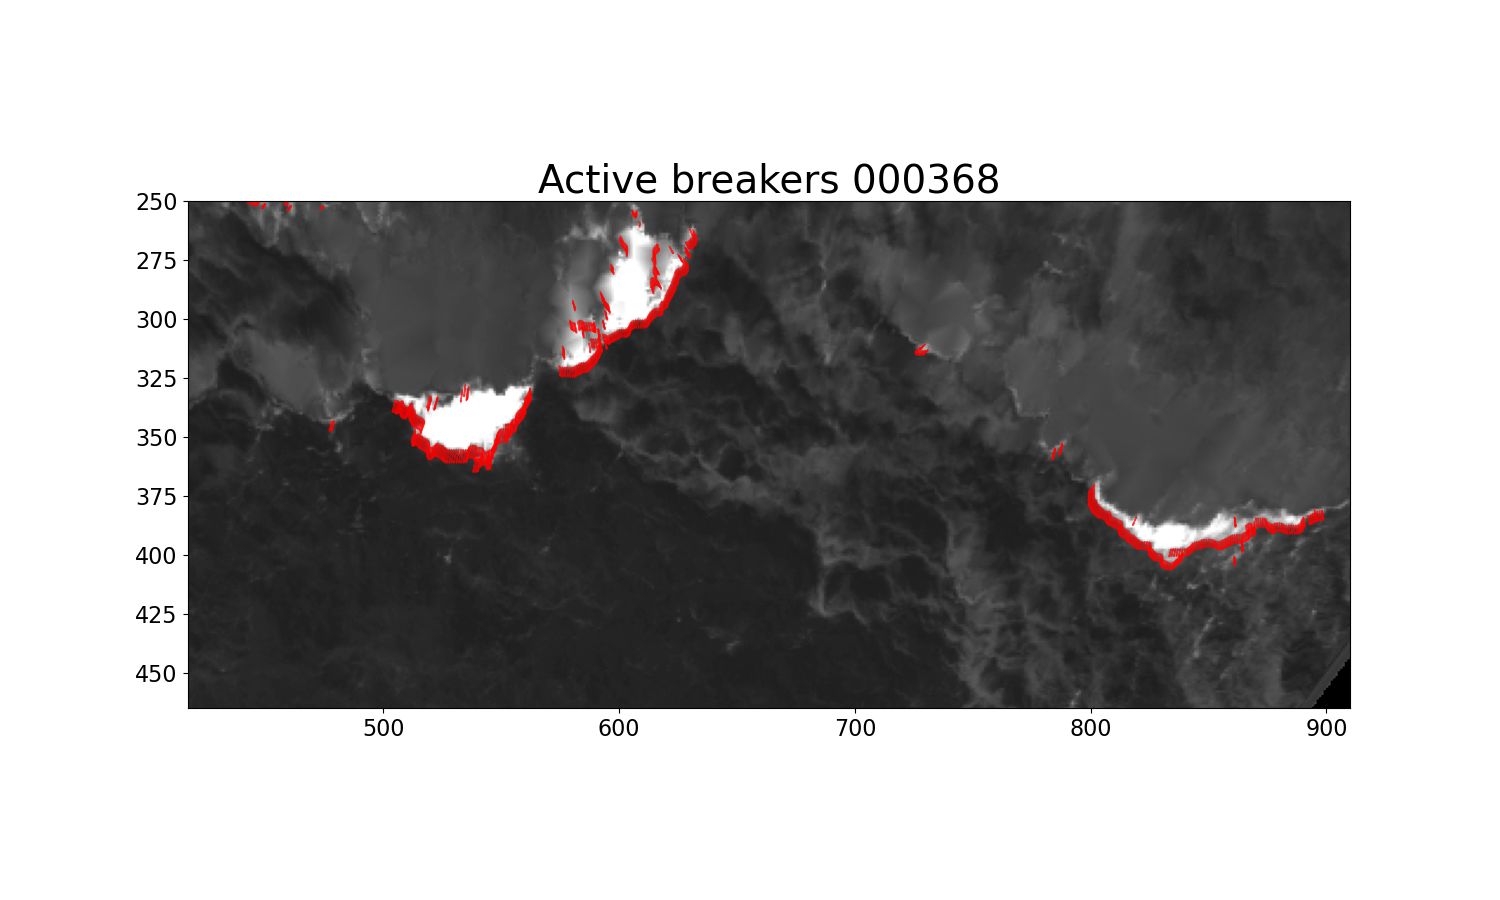

In [15]:
theta2 = detector.wrap_angpi(np.arctan2(CYo,CXo) -np.pi/2)
ind_forward = np.where((-np.pi/2<= theta2) & (theta2 <= np.pi/2)) #constrain to pi/2
ind_backward = np.where(~((-np.pi/2 <= theta2) & (theta2 <= np.pi/2)))

CXo_back, CYo_back, jnpo_back, inpo_back = CXo[ind_backward], CYo[ind_backward], inpo[ind_backward], jnpo[ind_backward]
CXo_forward, CYo_forward, jnpo_forward, inpo_forward= CXo[ind_forward], CYo[ind_forward], inpo[ind_forward], jnpo[ind_forward]

print('Working on frame ', frame_id)
if 1:        
    jump = 1  # just for better visualization
    plt.figure(figsize=(15, 9))
    plt.imshow(frame_a, cmap='gray', vmin = 30)

    for i in range(0, len(jnpo_forward)):
        plt.arrow(jnpo_forward[i], inpo_forward[i], CXo_forward[i], CYo_forward[i],
                  color='r', head_width=0.5, head_length=1.0, alpha=0.7)
    #plots forward arrows    
    for i in range(0, len(jnpo_back)):
        plt.arrow(jnpo_back[i], inpo_back[i], CXo_back[i], CYo_back[i],
                  color='b', head_width=0.5, head_length=1.0, alpha=0.7)

    # Increase tick label size
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().set_aspect('equal')
    plt.xlim([417, 910])
    plt.ylim([465,250 ])
    plt.title("Active breakers " + str(frame_id).zfill(6), fontsize = 28)
    if save:
        plt.savefig(figout[9]); print('saving figure')

## Save data

In [16]:
detector.save_loc_data(datapth, fname_savestats, C, frame_id, aTOT=aTOT,
                        ipc=ipc, jpc=jpc, CYi=CYi,CXi=CXi,
          CXo=CXo, CYo=CYo, my_dls=my_dls, jnpo=jnpo, inpo=inpo,
           Xa=Xa, Ya=Ya,Za=Za, frame_a=frame_a)

#pbar.update(10)
print(f' Saved at :{datapth}')


stop_time = time.time()
print('Analaysis area = ', '%.2f' % aTOT, 'm.sq')
print('contours detected with a threshold value of:' , '%.2f' % brightness_threshold)
#print (f'It took {0} mins to run this script !'.format(time.time()/60 - startTime/60))
print (f'It took', round((stop_time -startTime)/60, 2),'minutes to run this script !')
print("All done, the screen will be cleared in 5 secs.")

--------------------+--------------------------
LOC stats in m/s:   |
--------------------+--------------------------
    Cmin:           | 1.00
    Cmax:           | 5.23
    Cmean:          | 2.50
    Cmedian:        | 2.63
--------------------+--------------------------
 Saved at :../data/loc_output/AA201503MAIN_frame_000368_optical_flow.pkl
Analaysis area =  1984.65 m.sq
contours detected with a threshold value of: 0.60
It took 1.32 minutes to run this script !
All done, the screen will be cleared in 5 secs.


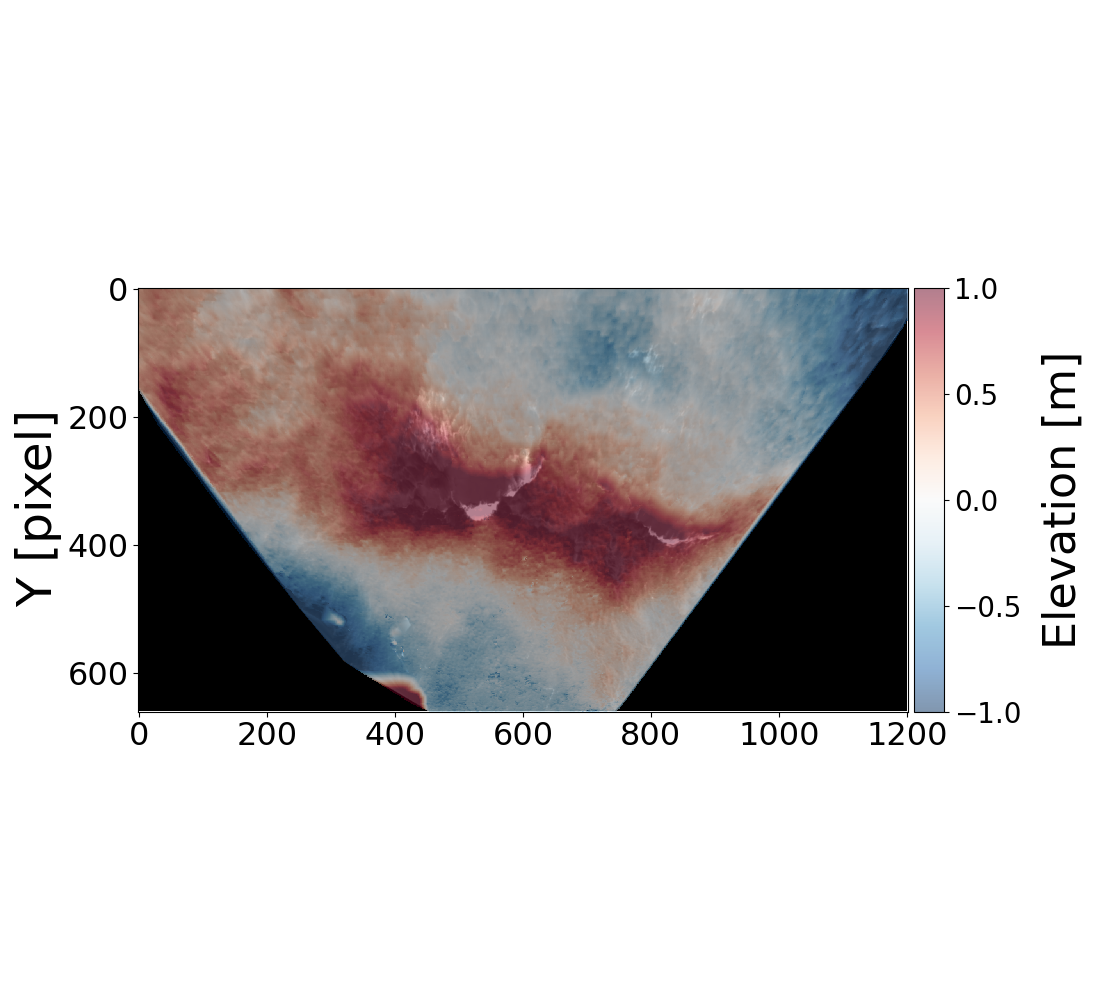

In [27]:
fig = plt.figure(figsize=(11,10))
fontsize = 35
plt.imshow(frame_b, cmap = 'gray', 
           origin = 'upper', vmin = 0.2)
ax = plt.gca()
c= plt.pcolormesh(Za, cmap= 'RdBu_r',
                            vmin= -1, vmax = 1, edgecolor=(1.0, 1.0, 1.0, 0.3), linewidth=0.0000625, 
                                alpha=0.5)
ax.set_aspect('equal')
plt.ylabel('Y [pixel] ' , fontsize = fontsize)
ax.tick_params(axis='both', labelsize=23)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.9%", pad=0.064)
ticks = np.arange(-1.0, +1.2, 0.5)

c=plt.colorbar(c, cax= cax, fraction=0.246,alpha =1, ticks= ticks)
c.set_label('Elevation [m]',fontsize = 32, labelpad=15)
c.ax.tick_params(labelsize=20)

plt.tight_layout()
# fig.savefig(figout[10])
